 Copyright © Sorbonne University.

 This source code is licensed under the MIT license found in the
 LICENSE file in the root directory of this source tree.


# **Authors**

*M2 SAR*

**DELPLANQUE Lisa**, lisa.delplanque@etu.sorbonne-universite.fr

**KIM Juyeon**, juyeon.kim@etu.sorbonne-universite.fr

# Outlook

In this notebook we will study basic reinforcement learning
algorithms: TD learning, Q-learning and SARSA. We will also investigate two
basic exploration strategies: $\epsilon$-greedy and softmax.


## Initialization

We begin by loading all the modules necessary for this notebook.

In [1]:
try:
    from easypip import easyimport
except ModuleNotFoundError:
    from subprocess import run
    assert run(["pip", "install", "easypip"]).returncode == 0, "Could not install easypip"
    from easypip import easyimport

easyimport("swig")
easyimport("bbrl_utils").setup(maze_mdp=True)

import os
from pathlib import Path
from typing import List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
from bbrl_utils.notebook import tqdm
from mazemdp.mdp import Mdp
from mazemdp.toolbox import egreedy, egreedy_loc, sample_categorical, softmax
from mazemdp import random_policy
import bbrl_gymnasium  # noqa: F401

# Settings
NB_EPISODES = 100
TIMEOUT = 25

[easypip] Installing swig
[easypip] Installing bbrl_utils


Matplotlib backend: module://matplotlib_inline.backend_inline


/usr/local/lib/python3.10/dist-packages/bbrl_utils/notebook.py:46: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # noqa: F401


# Reinforcement Learning

Reinforcement Learning is about finding the optimal policy in an MDP which is
initially unknown to the agent. More precisely, the state and action spaces
are known, but the agent does not know the transition and reward functions.
Generally speaking, the agent has to explore the MDP to figure out which
action in which state leads to which other state and reward. The model-free
case is about finding this optimal policy just through very local updates,
without storing any information about previous interactions with the
environment. Principles of these local updates can already be found in the
Temporal Difference (TD) algorithm, which iteratively computes optimal values
for all state using local updates. The most widely used model-free RL
algorithms are **q-learning**, **SARSA** and **actor-critic** algorithms.

As for dynamic programming, we first create a maze-like MDP. Reinforcement
learning is slower than dynamic programming, so we will work with smaller
mazes.

In [2]:
import gymnasium as gym

# Environment with 20% of walls and no negative reward when hitting a wall
env = gym.make(
    "MazeMDP-v0",
    kwargs={"width": 4, "height": 3, "ratio": 0.2, "hit": 0.0},
    render_mode="human",
)
env.reset()
env.unwrapped.init_draw("The maze")

       [-1,  2,  5,  8],
       [-1,  3,  6,  9]]), t…

# Temporal Difference (TD) learning ##

Given a state and an action spaces as well as a policy, TD(0) computes the
state value of this policy based on the following equations:

$$\delta_t = r(s_t,a_t) + \gamma V^{(i)}(s_{t+1})-V^{(i)}(s_t)$$
$$V^{(i+1)}(s_t) = V^{(i)}(s_t) + \alpha\delta_t$$

where $\delta$ is the TD error and $\alpha$ is a parameter called "learning
rate".

The code is provided below, so that you can take inspiration later on. The
important part is the computation of $\delta$, and the update of the values of
$V$.

To run TD learning, a policy is needed as input. Such a policy can be
retreived by using the `policy_iteration_q(mdp)` function defined in the
dynamic programming notebook.

If you want to run this notebook independently, you can use instead the
`random_policy` provided in `mazemdp`. This is what we do here by default,
replace it if you want to run TD learning from an optimal policy.

The ```evaluate``` function below is not necessary for the lab, it is left here for its informative value.

In [3]:
def evaluate(mdp, policy):
    x, _ = mdp.reset(uniform=True)
    done = False
    reward = 0

    while not done:
        # Perform a step of the MDP
        u = sample_categorical(policy[x])
        _, r, done, *_ = mdp.step(u)
        reward += r
    return reward

**Question:** In the code of the *temporal_difference(...)* function below,
fill the missing parts

In [4]:
def temporal_difference(
    mdp: MazeMDPEnv,
    policy: np.ndarray,
    nb_episodes: int = 50,
    alpha: float = 0.2,
    timeout: int = 25,
    render: bool = True,
) -> np.ndarray:
    # alpha: learning rate
    # timeout: timeout of an episode (maximum number of timesteps)
    v = np.zeros(mdp.unwrapped.nb_states)  # initial state value v
    mdp.timeout = timeout

    if render:
        mdp.unwrapped.init_draw("Temporal differences")

    for _ in tqdm(range(nb_episodes)):  # for each episode

        # Draw an initial state randomly (if uniform is set to False, the state
        # is drawn according to the P0 distribution)
        x, _ = mdp.reset(uniform=True)
        terminated = False
        truncated = False
        while not (terminated or truncated):
            # Show agent
            if render:
                mdp.unwrapped.draw_v_pi(v, policy)

            # Step forward following the MDP: x=current state, pol[i]=agent's
            # action according to policy pol, r=reward gained after taking
            # action pol[i], terminated=tells whether  the episode ended, and info
            # gives some info about the process
            y, r, terminated, truncated, _ = mdp.step(
                egreedy_loc(policy[x], mdp.action_space.n, epsilon=0.2)
            )
            # To be completed...

            # Update the state value of x
            delta = r + mdp.gamma * v[y] - v[x] # compute the TD error
            v[x] = v[x] + alpha * delta # update the values of V
            #assert False, 'Not implemented yet'


            # Update agent's position (state)
            x = y

    if render:
        mdp.current_state = 0
        mdp.unwrapped.draw_v_pi(v, policy)
    return v

Once this is done, you can run it.

In [5]:
policy = random_policy(env)
v = temporal_difference(env, policy, nb_episodes=10, timeout=TIMEOUT)

  logger.warn(



       [-1,  2,  5,  8],
       [-1,  3,  6,  9]]), t…

  0%|          | 0/10 [00:00<?, ?it/s]

  logger.warn(



Unless you were lucky, the generated value function is boring: if the policy
does not reach the final state, all values are 0. To avoid this, you can
copy-paste a dynamic programming function on the Q function from the previous
notebook, use it to get an optimal policy, and use this policy for TD
learning. You should get a much more interesting value function.

In [6]:
# Put your code to get a policy from a Q function here
def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    # Outputs a policy given the action values

    return np.argmax(q, axis=1)
#assert False, 'Not implemented yet'


In [7]:
def evaluate_one_step_q(
    mdp: MazeMDPEnv, q: np.ndarray, policy: np.ndarray
) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    qnew = np.zeros(
        (mdp.nb_states, mdp.action_space.n)
    )  # initial action values are set to 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        for u in range(mdp.action_space.n):
            if x in mdp.terminal_states:
                qnew[x, u] = mdp.r[x, u]
            else:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    # To be completed...

                    summ += mdp.P[x, u ,y] * q[y, policy[y]]
                    #assert False, 'Not implemented yet'


                # To be completed...

                qnew[x, u] = mdp.r[x,u] + mdp.gamma * summ
                #assert False, 'Not implemented yet'

    return qnew

In [8]:
def evaluate_q(mdp: MazeMDPEnv, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function of a policy
    q = np.zeros(
        (mdp.nb_states, mdp.action_space.n)
    )  # initial action values are set to 0
    stop = False
    while not stop:
        qold = q.copy()

        # To be completed...

        q = evaluate_one_step_q(mdp, qold, policy)
        #assert False, 'Not implemented yet'


        # Test if convergence has been reached
        if (np.linalg.norm(q - qold)) < 0.01:
            stop = True
    return q

In [9]:
# Put your code to obtain an optimal Q function here
# ---------------- Policy Iteration with the Q function -----------------#
# Given a MDP, this algorithm simultaneously computes
# the optimal action value function Q and the optimal policy


def policy_iteration_q(
    mdp: MazeMDPEnv, render: bool = True
) -> Tuple[np.ndarray, List[float]]:
    """policy iteration over the q function."""
    q = np.zeros(
        (mdp.nb_states, mdp.action_space.n)
    )  # initial action values are set to 0
    q_list = []
    policy = random_policy(mdp)

    stop = False

    mdp.init_draw("Policy iteration Q")

    while not stop:
        qold = q.copy()
        mdp.draw_v(q)

        # Step 1 : Policy evaluation

        q = evaluate_q(mdp, policy)
        #assert False, 'Not implemented yet'


        # Step 2 : Policy improvement

        policy = get_policy_from_q(q)
        #assert False, 'Not implemented yet'
        # Check convergence
        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))

    mdp.draw_v_pi(q, get_policy_from_q(q))
    return q, q_list


In [10]:
# obtain an optimal Q function
q, _ = policy_iteration_q(env, render=False)

# get a policy from a Q function
policy = get_policy_from_q(q)

# run the algorithm
v = temporal_difference(env, policy, nb_episodes=10, timeout=TIMEOUT)
#assert False, 'Not implemented yet'


  logger.warn(



       [-1,  2,  5,  8],
       [-1,  3,  6,  9]]), t…

  logger.warn(

  logger.warn(

  logger.warn(

  logger.warn(

  logger.warn(



  0%|          | 0/10 [00:00<?, ?it/s]

# Q-learning ##

The **q-learning** algorithm accounts for an agent exploring an MDP and
updating at each step a model of the state action-value function stored into a
Q-table. It is updated as follows:

$$
\delta_t = \left( r(s_t,a_t) + \gamma \max_{a \in A}
Q^{(i)}(s_{t+1},a) \right) -Q^{(i)}(s_t,a_t)
$$

$$Q^{(i+1)}(s_t, a_t) = Q^{(i)}(s_t,a_t) + \alpha \delta_t$$

To visualize the policy, we need the `get_policy_from_q(q)` function that we defined in the
dynamic programming notebook. If you have not done so yet, import it below.

In [11]:
# Put your code here
policy = get_policy_from_q(q)
#assert False, 'Not implemented yet'


Fill the code of the `q_learning(...)` function below.

In [12]:
# --------------------------- Q-Learning epsilon-greedy version -------------------------------#
# Given an exploration rate epsilon, the QLearning algorithm computes the state action-value function
# based on an epsilon-greedy policy
# alpha is the learning rate


def q_learning_eps(
    mdp: MazeMDPEnv,
    epsilon: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    gamma: float = 0.9,
    render: bool = True,
    init_q: float = 0.0,
    uniform: bool = True,
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.n))
    q[:, :] = init_q
    q_list = []
    time_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Q Learning")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=uniform)
        cpt = 0

        terminated = False
        truncated = False
        while not (terminated or truncated):
            # Show the agent in the maze
            if render:
                mdp.draw_v_pi(q, q.argmax(axis=1))

            # Draw an action using an epsilon-greedy policy
            u = egreedy(q, x, epsilon)

            # Perform a step of the MDP
            y, r, terminated, truncated, _ = mdp.step(u)

            # To be completed...

            # Update the state-action value function with q-Learning
            delta = r+ gamma * np.max(q[y, :]) - q[x, u]
            q[x, u] = q[x, u] + alpha * delta
            #assert False, 'Not implemented yet'


            # Update the agent position
            x = y
            cpt = cpt + 1

        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    if render:
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q))

    return q, q_list, time_list

And run it.

In [13]:
epsilon = 0.02
q, q_list, time_list = q_learning_eps(
    env, epsilon, nb_episodes=NB_EPISODES, timeout=TIMEOUT
)

       [-1,  2,  5,  8],
       [-1,  3,  6,  9]]), t…

## Harder case: fixed starting point and exploration

We now explore the case where the agent always start at the *beginning of the maze* (`uniform=False`), corresponding to the top-left corner when this is a free cell.

In [14]:
epsilon = 0.02
start_q, start_q_list, time_list = q_learning_eps(
    env, epsilon, nb_episodes=NB_EPISODES, timeout=TIMEOUT, uniform=False
)

       [-1,  2,  5,  8],
       [-1,  3,  6,  9]]), t…

You will observe that it is very difficult for the agent to learn to reach the
final state (and the larger the maze, the more difficult). A simple trick to
avoid this is to initialize the value of each $(s,a)$ pair to a small (lower
than the final reward) value. Try it with the example above !

In [15]:
# To be completed...

# Put your code to run q_learning_eps here
#assert False, 'Not implemented yet'
init_q= 1
epsilon = 0.02
start_q, start_q_list, time_list = q_learning_eps(
    env, epsilon, nb_episodes=NB_EPISODES, timeout=TIMEOUT,init_q=init_q, uniform=False
)


       [-1,  2,  5,  8],
       [-1,  3,  6,  9]]), t…

### Learning dynamics

By watching carefully the values while the agent is learning, you can see that
the agent favors certains paths over others which have a strictly equivalent value.
This can be explained easily: as the agent chooses a path for the first
time, it updates the values along that path, these values get higher than the
surrounding values, and the agent chooses the same path again and again,
increasing the phenomenon. Only steps of random exploration can counterbalance
this effect, but they do so extremely slowly.

### Exploration

In the `q_learning(...)` function above, action selection is based on a
$\epsilon$-greedy policy. Instead, it could have relied on *`softmax`*.

In the function below, you have to replace the call to the
previous *$\epsilon$-greedy* policy with a `softmax` policy. The
`softmax(...)` and `egreedy(...)` functions are available in
`mazemdp.toolbox`.

`sofmax(...)` returns a distribution probability over actions. To sample
an action according to their probabilities, you can use the
`sample_categorical` function.

In [16]:

# --------------------------- Q-Learning softmax version ----------------------------#
# Given a temperature "beta", the QLearning algorithm computes the state action-value function
# based on a softmax policy
# alpha is the learning rate


def q_learning_soft(
    mdp: MazeMDPEnv,
    beta: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    gamma: float = 0.9,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_list = []
    time_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Q Learning (Softmax)")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=True)
        cpt = 0

        terminated = False
        truncated = False
        while not (terminated or truncated):
            if render:
                mdp.draw_v_pi(q, q.argmax(axis=1))

            # To be completed...

            # Draw an action using a soft-max policy
            u = sample_categorical(softmax(q,x, temperature=beta)) # (here, call the softmax function)
            #assert False, 'Not implemented yet'


            # To be completed...

            # Copy-paste the rest from q_learning_eps
            #assert False, 'Not implemented yet'
            y, r, terminated, truncated, _ = mdp.step(u)
            delta = r + gamma * np.max(q[y, :]) - q[x, u]
            q[x, u] = q[x, u] + alpha * delta

            x = y
            cpt = cpt + 1

        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    if render:
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q))

    return q, q_list, time_list

 Run this new version

In [17]:
NB_EPISODES = 40
beta = 6
q, q_list, time_list = q_learning_soft(
    env, beta, nb_episodes=NB_EPISODES, timeout=TIMEOUT
)

       [-1,  2,  5,  8],
       [-1,  3,  6,  9]]), t…

# Sarsa

The **sarsa** algorithm is very similar to **q-learning**. At first glance,
the only difference is in the update rule. However, to perform the update in
**sarsa**, one needs to know the action the agent will take when it will be at
the next state, even if the agent is taking a random action.

This implies that the next state action is determined in advance and stored
for being played at the next time step.

The update formula is as follows:

$$ \delta_t = \left( r(s_t,a_t) + \gamma Q^{(i)}(s_{t+1}, a_{t+1})
\right) -Q^{(i)}(s_t,a_t) $$

$$ Q^{(i+1)}(s_t,a_t) = Q^{(i)}(s_t,a_t) + \alpha \delta_t $$



## SARSA ($\epsilon-greedy$ version)
Fill the code below

In [18]:
# Given an exploration rate epsilon, the SARSA algorithm computes the state action-value function
# based on an epsilon-greedy policy
# alpha is the learning rate


def sarsa_eps(
    mdp: MazeMDPEnv,
    epsilon: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    gamma: float = 0.9,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_list = []
    time_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Sarsa e-greedy")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=True)
        cpt = 0

        # To be completed...

        # Fill this part of the code
        #assert False, 'Not implemented yet'
        ####
        # Draw an action using an epsilon-greedy policy
        u = egreedy(q, x, epsilon)

        terminated = False
        truncated = False

        while not (terminated or truncated):
            if render:
                mdp.draw_v_pi(q, q.argmax(axis=1))

            # Perform a step of the MDP
            y, r, terminated, truncated, _ = mdp.step(u)

            # Draw the next action using an epsilon-greedy policy
            u_next = egreedy(q, y, epsilon)

            # Update the state-action value function with SARSA
            delta = r + gamma * q[y, u_next] - q[x, u]
            q[x, u] += alpha * delta

            # Update the agent position
            x = y
            u = u_next
            cpt += 1
        ####
        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    if render:
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q))
    return q, q_list, time_list

And run it.

In [19]:
epsilon = 0.02
q, q_list, time_list = sarsa_eps(env, epsilon, nb_episodes=NB_EPISODES, timeout=TIMEOUT)

       [-1,  2,  5,  8],
       [-1,  3,  6,  9]]), t…

As for **q-learning** above, copy-paste the resulting code to get a
*sarsa_soft(...)* and a *sarsa_eps(...)* function.

In [20]:
# --------------------------- Sarsa, softmax version -------------------------------#
# Given a temperature "beta", the SARSA algorithm computes the state action-value function
# based on a softmax policy
# alpha is the learning rate


def sarsa_soft(
    mdp: MazeMDPEnv,
    beta: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    gamma: float = 0.9,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:

    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_list = []
    time_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Sarsa (Softmax)")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=True)
        cpt = 0

        # To be completed...

        # Fill this part of the code
        #assert False, 'Not implemented yet'
        ####
        # Draw an action using an epsilon-greedy policy
        u = sample_categorical(softmax(q,x,beta))

        terminated = False
        truncated = False

        while not (terminated or truncated):
            if render:
                mdp.draw_v_pi(q, q.argmax(axis=1))

            # Perform a step of the MDP
            y, r, terminated, truncated, _ = mdp.step(u)

            # select next action using softmax over q-values
            u_next = sample_categorical(softmax(q,y, beta))

            # Update the state-action value function with SARSA
            delta = r + gamma * q[y, u_next] - q[x, u]
            q[x, u] += alpha * delta  # Update Q value

            # updates
            x = y
            u = u_next
            cpt += 1
        ####

        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    if render:
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q))
    return q, q_list, time_list

And run it.

In [21]:
# To be completed...

# Put your code to run sarsa_soft here
#assert False, 'Not implemented yet'
epsilon = 0.02
q, q_list, time_list = sarsa_soft(env, epsilon, nb_episodes=NB_EPISODES, timeout=TIMEOUT)

       [-1,  2,  5,  8],
       [-1,  3,  6,  9]]), t…

# Study part


### Impact of `epsilon` and `beta` on q-learning and sarsa

Compare the number of steps needed by **q-learning** and **sarsa** to converge
on a given MDP using the *softmax* and *$\epsilon$-greedy* exploration
strategies. To figure out, you can use the provided `plot_ql_sarsa(m, epsilon,
beta, nb_episodes, timeout, alpha, render)` function below with various values
for $\epsilon$ (e.g. 0.001, 0.01, 0.1) and $\beta$ (e.g. 0.1, 5, 10) and
comment the obtained curves. Other visualizations are welcome.

Note that instead of the temperature `beta`, computational neuroscience
researchers, who generally prefer softmax exploration, use a parameter `beta`
which behaves as an inverse of the temperature. That way, the three
hyper-parameters of basic tabular RL algorithms are `alpha`, `beta`, and
`gamma`.

In [22]:
# -------- plot learning curves of Q-Learning and Sarsa using epsilon-greedy and softmax ----------#
def plot_ql_sarsa(env, epsilon, beta, nb_episodes, timeout, alpha, render):
    q, q_list1, time_list1 = q_learning_eps(
        env, epsilon, nb_episodes, timeout, alpha, render = render
    )
    q, q_list2, time_list2 = q_learning_soft(
        env, beta, nb_episodes, timeout, alpha, render =render
    )
    q, q_list3, time_list3 = sarsa_eps(
        env, epsilon, nb_episodes, timeout, alpha, render =render
    )
    q, q_list4, time_list4 = sarsa_soft(env, beta, nb_episodes, timeout, alpha, render = render)

    plt.clf()
    plt.plot(range(len(q_list1)), q_list1, label="q-learning e-greedy")
    plt.plot(range(len(q_list2)), q_list2, label="q-learning softmax")
    plt.plot(range(len(q_list3)), q_list3, label="sarsa e-greedy")
    plt.plot(range(len(q_list4)), q_list4, label="sarsa softmax")

    plt.xlabel("Number of episodes")
    plt.ylabel("Norm of Q values")
    plt.legend(loc="upper right")
    # plt.savefig("comparison_RL.png")
    plt.title("Comparison of convergence rates")
    plt.show()

    plt.clf()
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(time_list1)), time_list1, label="qlearning e-greedy")
    plt.plot(range(len(time_list2)), time_list2, label="qlearning softmax")
    plt.plot(range(len(time_list3)), time_list3, label="sarsa e-greedy")
    plt.plot(range(len(time_list4)), time_list4, label="sarsa softmax")

    plt.xlabel("Number of episodes")
    plt.ylabel("Steps to reach goal")
    plt.legend(loc="upper right")
    # plt.savefig("comparison_RL.png")
    plt.title("test")
    plt.show()

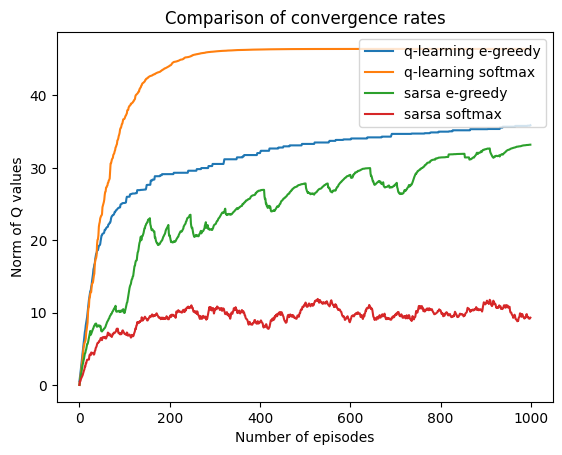

<Figure size 640x480 with 0 Axes>

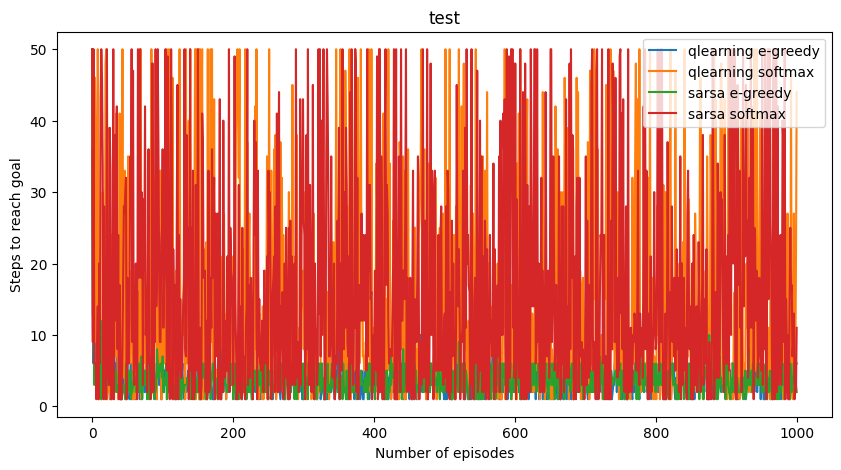

In [23]:
# example
plot_ql_sarsa(
    env, epsilon=0.02, beta=6, nb_episodes=1000, timeout=100, alpha=0.5, render=False
)

**Comment**:

Comparison of convergence rates:
 1. Q-learning with softmax (orange line) converges the fastest and reaches the highes Q-value norm. It shows rapid inital learninga and then stabilizes around episode 300.
 2. Q-learning with ɛ-greedy (blue line) shows slower but steady convergence, eventually reaching the second highest Q-value norm.
 3. SARSA with ɛ-greedy (green line) and SARSA with softmax (red line) show slow convergence, and improvement near the end of the episodes.

Steps to reach goal
- Q-learning and SARSA with softmax require more steps to reach the goal. They show high variability in performance, characterized by high peks.
- Q-learning and SARA with ɛ-greedy generally require fewer steps to reach goal.

Running for epsilon=0.001 and beta=0.1...


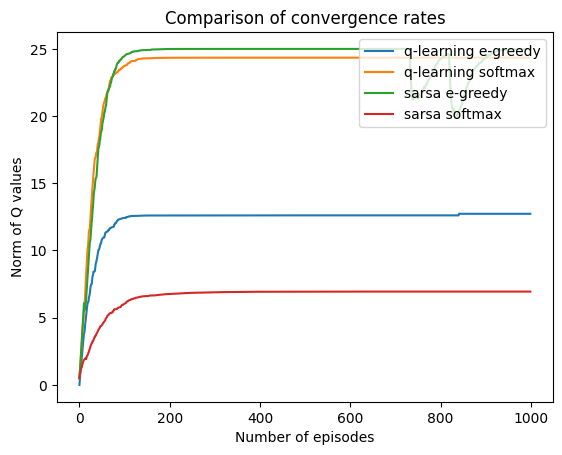

<Figure size 640x480 with 0 Axes>

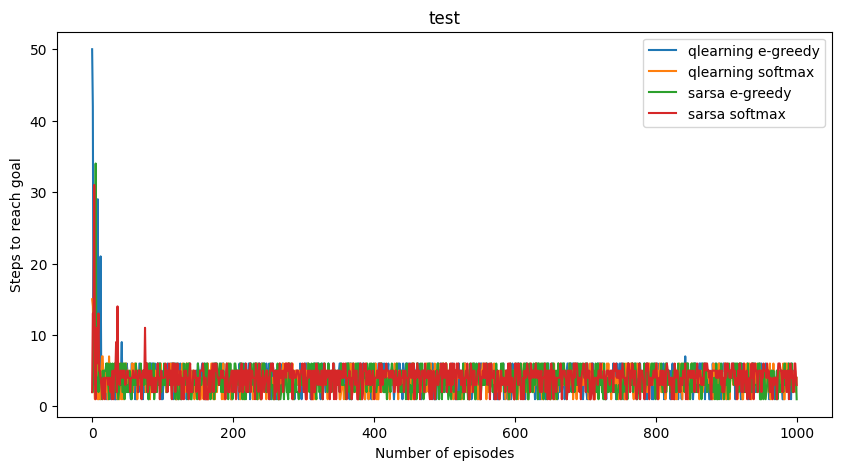

Running for epsilon=0.001 and beta=5...


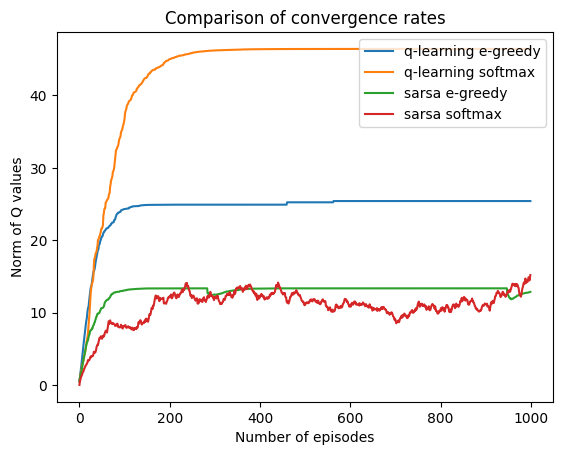

<Figure size 640x480 with 0 Axes>

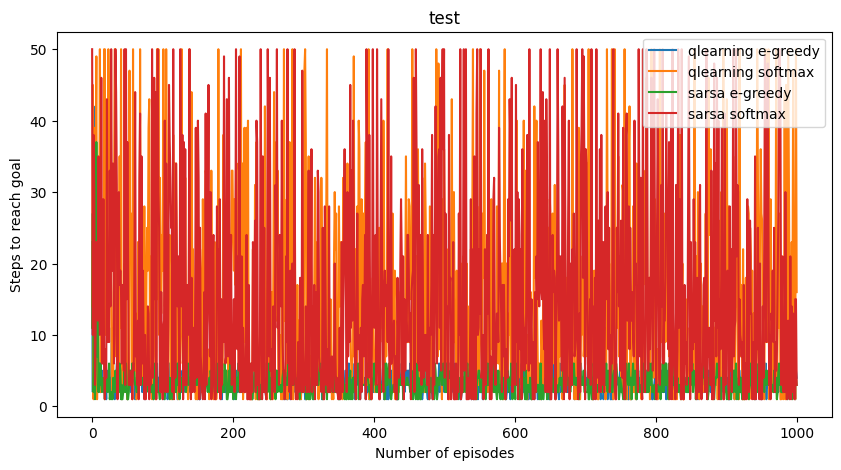

Running for epsilon=0.001 and beta=10...


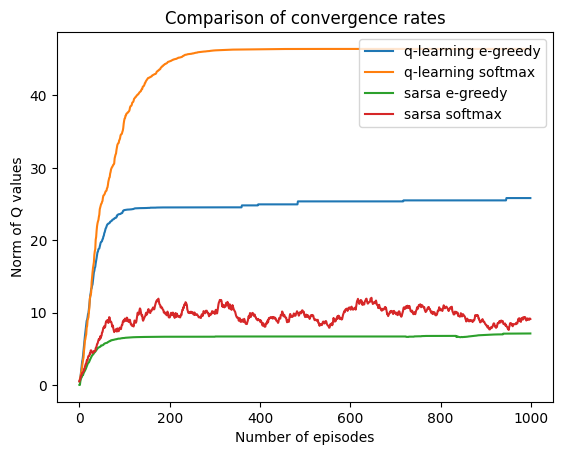

<Figure size 640x480 with 0 Axes>

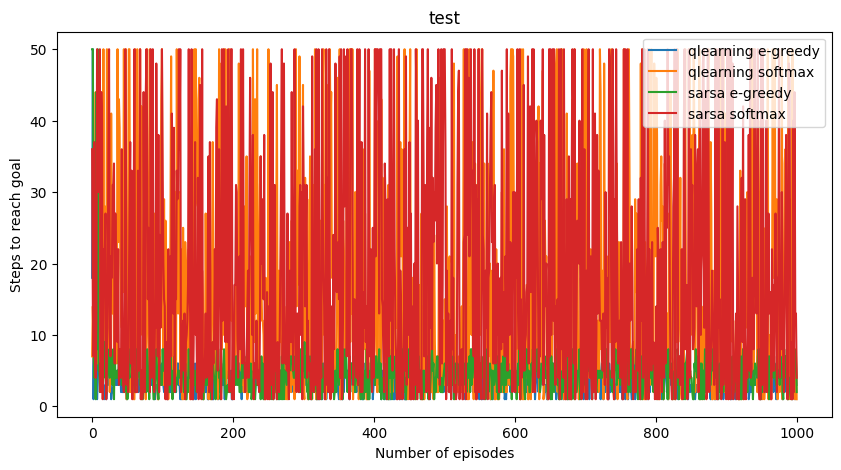

Running for epsilon=0.01 and beta=0.1...


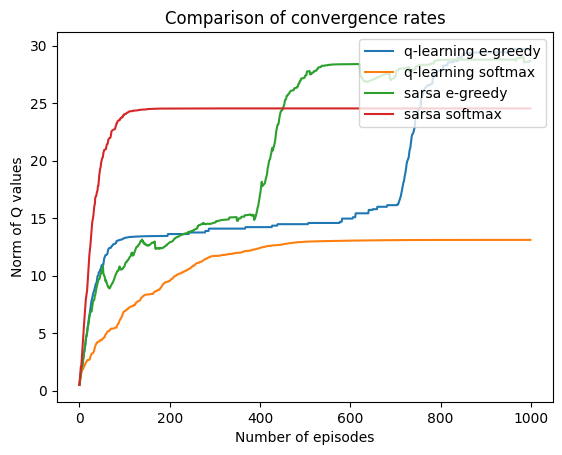

<Figure size 640x480 with 0 Axes>

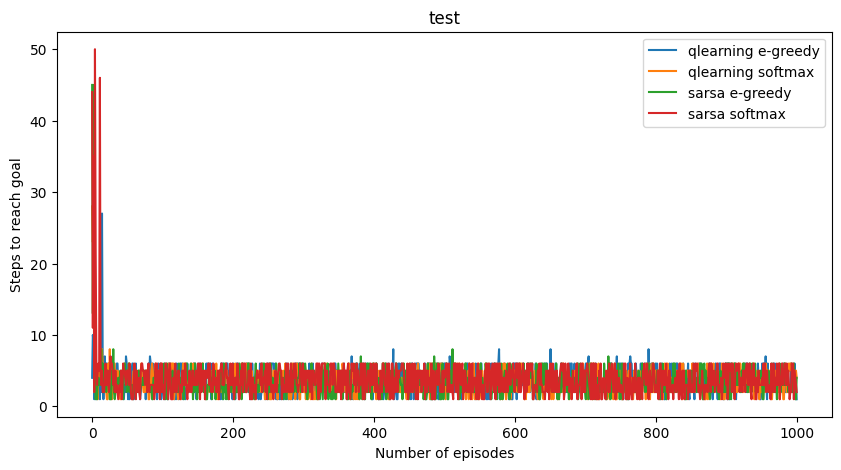

Running for epsilon=0.01 and beta=5...


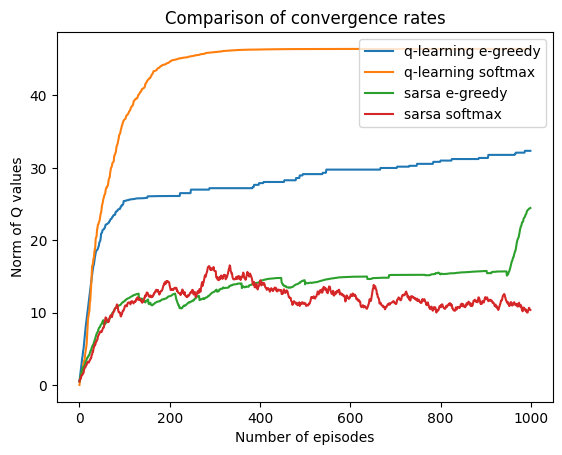

<Figure size 640x480 with 0 Axes>

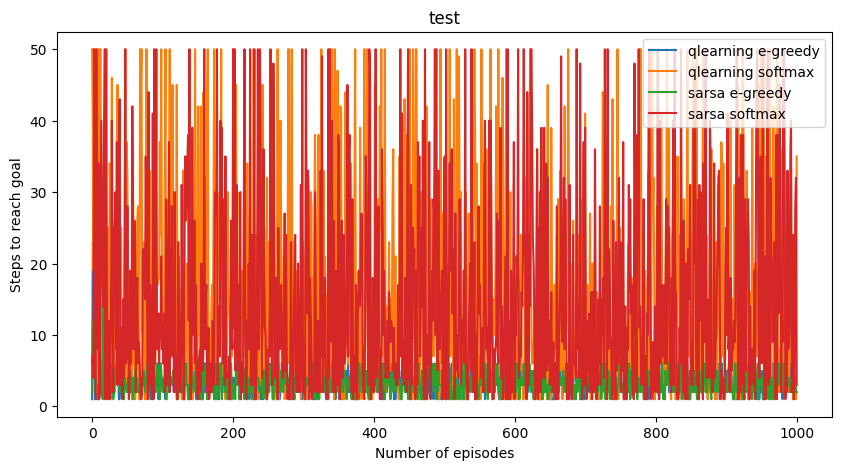

Running for epsilon=0.01 and beta=10...


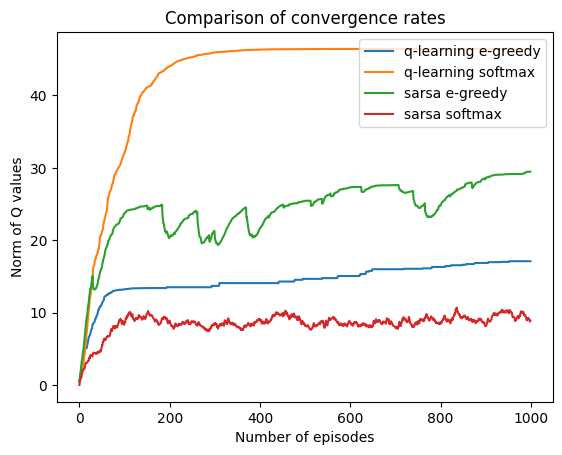

<Figure size 640x480 with 0 Axes>

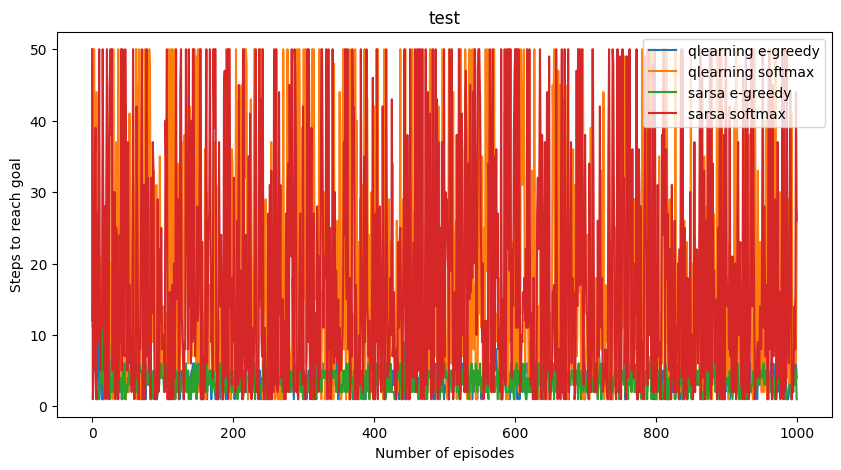

Running for epsilon=0.1 and beta=0.1...


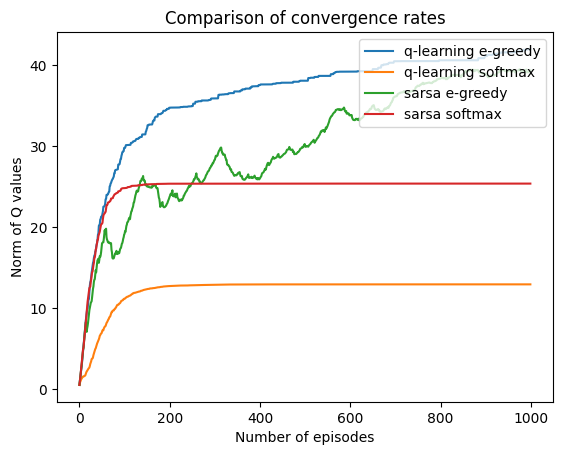

<Figure size 640x480 with 0 Axes>

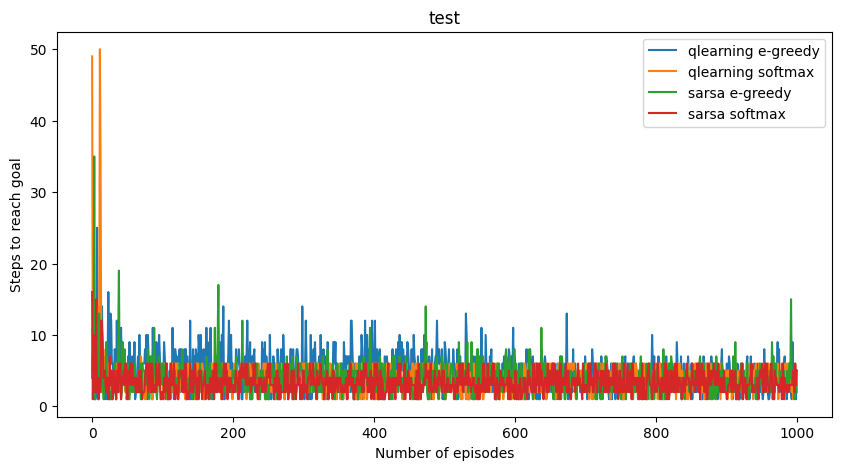

Running for epsilon=0.1 and beta=5...


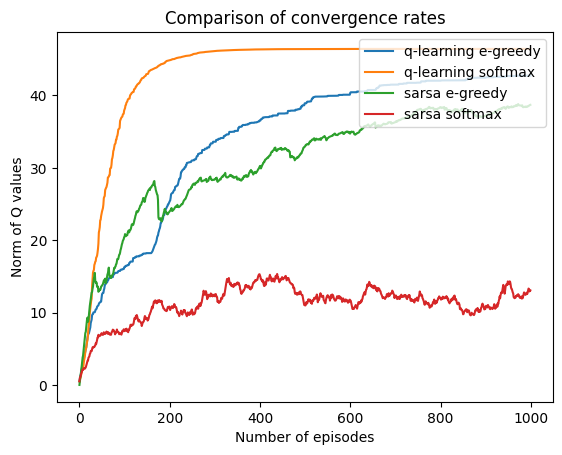

<Figure size 640x480 with 0 Axes>

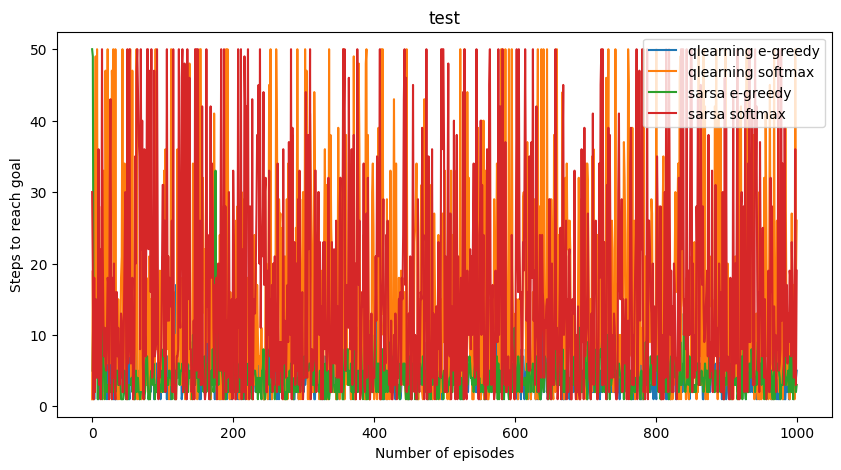

Running for epsilon=0.1 and beta=10...


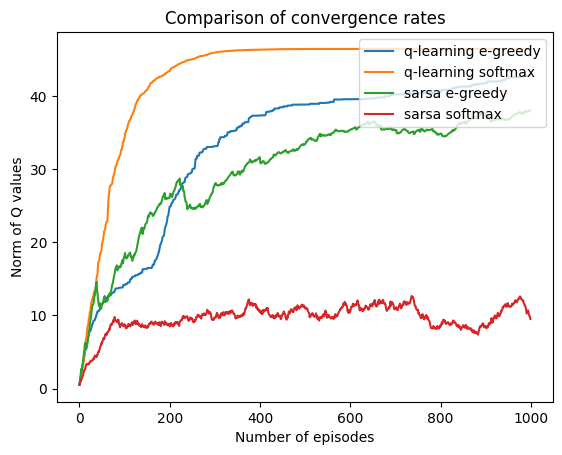

<Figure size 640x480 with 0 Axes>

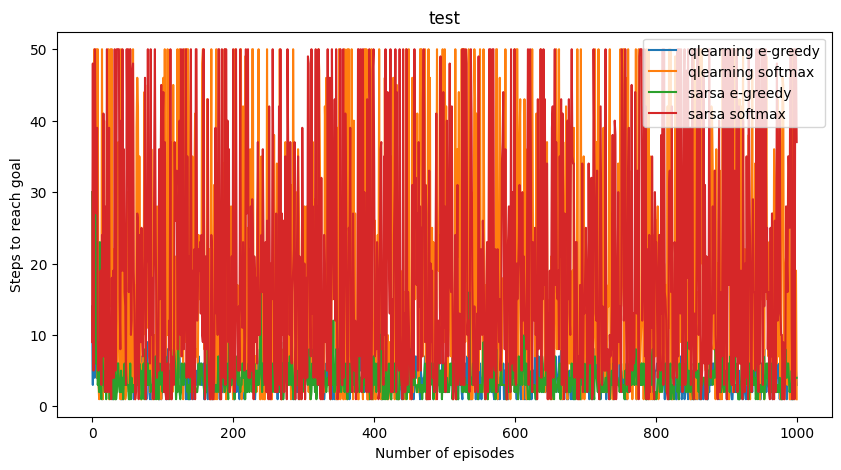

In [24]:

# Values to test for epsilon and beta
epsilon_values = [0.001, 0.01, 0.1]
beta_values = [0.1, 5, 10]

# Loop over each combination of epsilon and beta
for epsilon in epsilon_values:
    for beta in beta_values:
        print(f"Running for epsilon={epsilon} and beta={beta}...")
        # Run the plot function for each combination
        plot_ql_sarsa(
            env, epsilon=epsilon, beta=beta, nb_episodes=1000, timeout=100, alpha=0.5, render=False
        )


**Comments** : Since we vary epsilon and beta at the same time, the graphs are somewhat difficult to analyze. Moreover, it's not necessary to vary them simultaneously, as epsilon affects the q-learning and SARSA e-greedy algorithms, while beta impacts the softmax-based algorithms.

Running for epsilon=0.001...


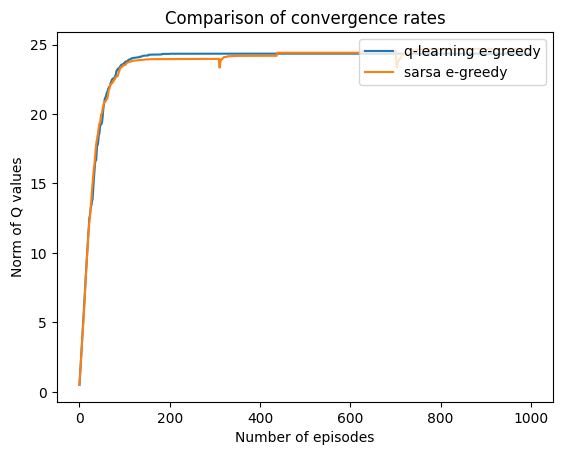

<Figure size 640x480 with 0 Axes>

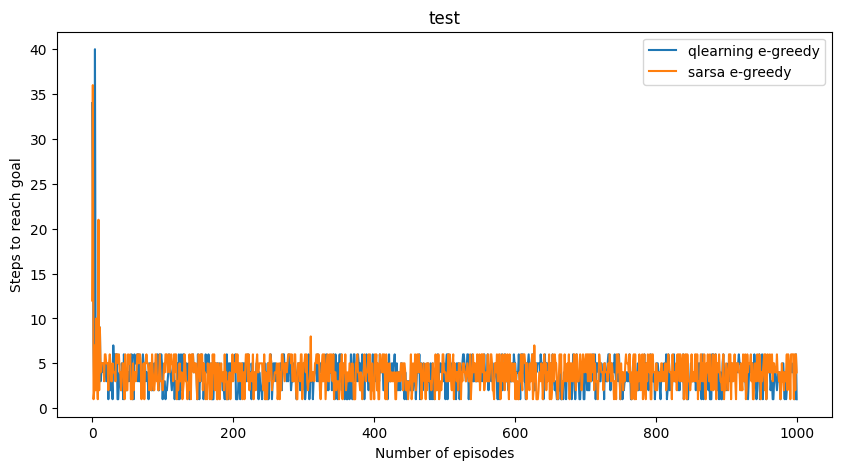

Running for epsilon=0.01...


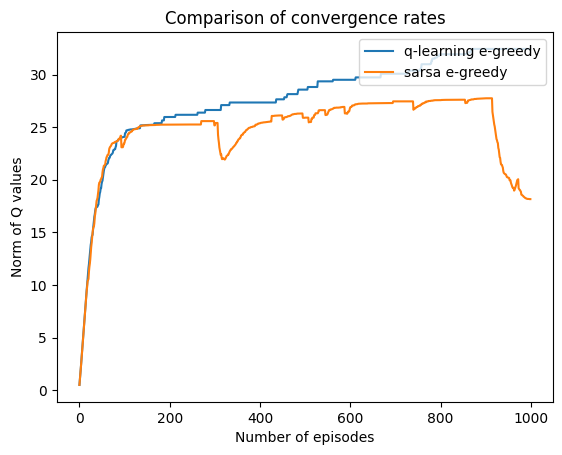

<Figure size 640x480 with 0 Axes>

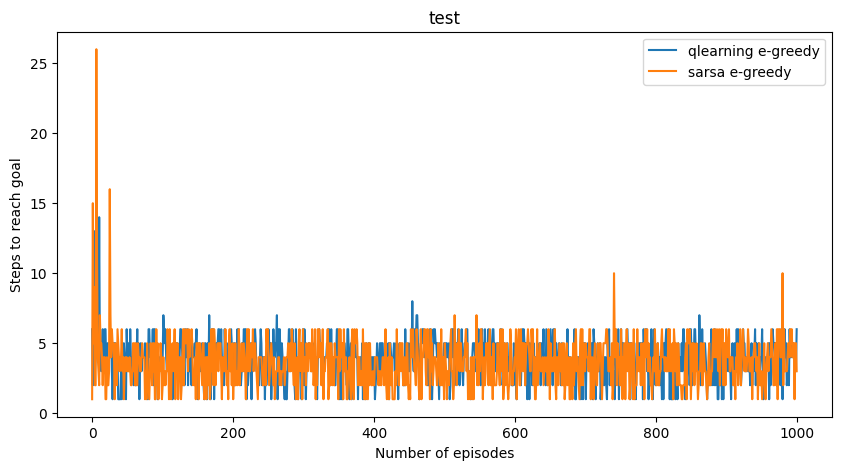

Running for epsilon=0.1...


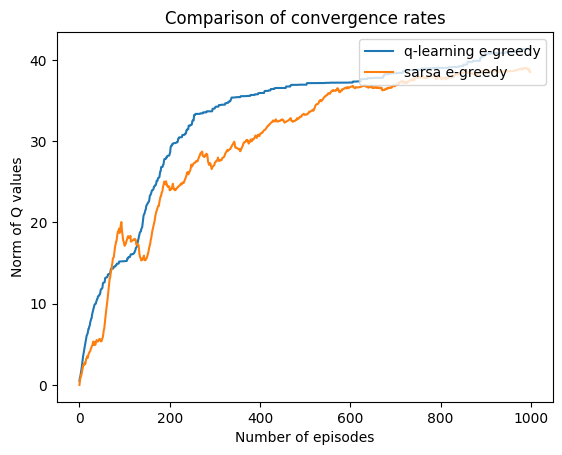

<Figure size 640x480 with 0 Axes>

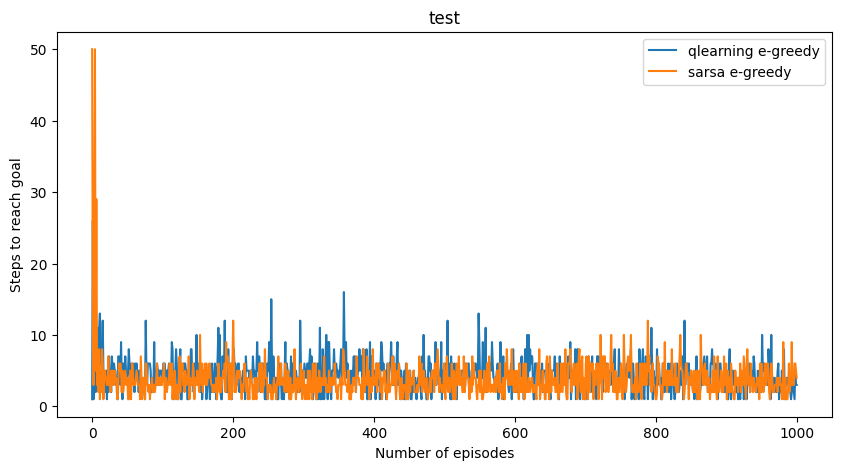

In [25]:
# -------- plot learning curves of Q-Learning and Sarsa using epsilon-greedy ----------#
def plot_ql_sarsa_egreedy(env, epsilon, nb_episodes, timeout, alpha, render):
    q, q_list1, time_list1 = q_learning_eps(
        env, epsilon, nb_episodes, timeout, alpha, render=render
    )
    q, q_list3, time_list3 = sarsa_eps(
        env, epsilon, nb_episodes, timeout, alpha, render=render
    )

    plt.clf()
    plt.plot(range(len(q_list1)), q_list1, label="q-learning e-greedy")
    plt.plot(range(len(q_list3)), q_list3, label="sarsa e-greedy")

    plt.xlabel("Number of episodes")
    plt.ylabel("Norm of Q values")
    plt.legend(loc="upper right")
    # plt.savefig("comparison_RL.png")
    plt.title("Comparison of convergence rates")
    plt.show()

    plt.clf()
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(time_list1)), time_list1, label="qlearning e-greedy")
    plt.plot(range(len(time_list3)), time_list3, label="sarsa e-greedy")

    plt.xlabel("Number of episodes")
    plt.ylabel("Steps to reach goal")
    plt.legend(loc="upper right")
    # plt.savefig("comparison_RL.png")
    plt.title("test")
    plt.show()

# Boucle pour tester différentes valeurs de epsilon (e-greedy)
epsilon_values = [0.001, 0.01, 0.1]

for epsilon in epsilon_values:
    print(f"Running for epsilon={epsilon}...")
    # Appel de la fonction avec un paramètre epsilon et un beta arbitraire (ne sera pas utilisé)
    plot_ql_sarsa_egreedy(
        env, epsilon=epsilon, nb_episodes=1000, timeout=100, alpha=0.5, render=False
    )


Running for epsilon=0.001
Running for epsilon=0.002
Running for epsilon=0.003
Running for epsilon=0.004
Running for epsilon=0.005
Running for epsilon=0.006
Running for epsilon=0.007
Running for epsilon=0.008
Running for epsilon=0.009
Running for epsilon=0.01


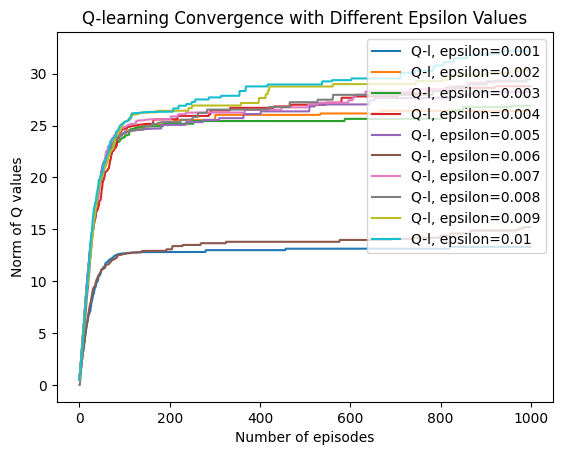

Running for epsilon=0.001
Running for epsilon=0.002
Running for epsilon=0.003
Running for epsilon=0.004
Running for epsilon=0.005
Running for epsilon=0.006
Running for epsilon=0.007
Running for epsilon=0.008
Running for epsilon=0.009
Running for epsilon=0.01


<Figure size 640x480 with 0 Axes>

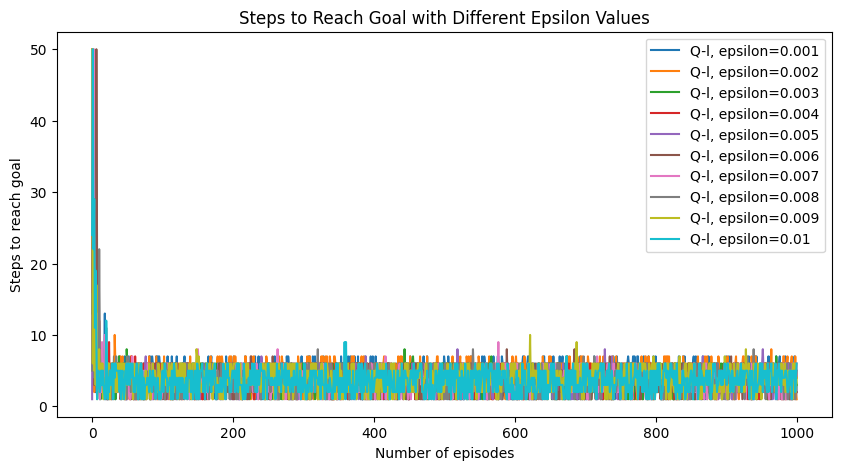

In [39]:
# -------- plot learning curves of Q-Learning with different epsilon values ----------#
def plot_ql_different_epsilons(env, epsilon_values, nb_episodes, timeout, alpha, render):
    plt.clf()
    for epsilon in epsilon_values:
        print(f"Running for epsilon={epsilon}")
        q, q_list, time_list = q_learning_eps(
            env, epsilon, nb_episodes, timeout, alpha, render=render
        )

        # Plot the Q-learning norm curves for each epsilon
        plt.plot(range(len(q_list)), q_list, label=f"Q-l, epsilon={epsilon}")

    plt.xlabel("Number of episodes")
    plt.ylabel("Norm of Q values")
    plt.legend(loc="upper right")
    plt.title("Q-learning Convergence with Different Epsilon Values")
    plt.show()

    plt.clf()
    plt.figure(figsize=(10, 5))
    for epsilon in epsilon_values:
        print(f"Running for epsilon={epsilon}")
        q, q_list, time_list = q_learning_eps(
            env, epsilon, nb_episodes, timeout, alpha, render=render
        )

        # Plot the steps-to-goal curves for each epsilon
        plt.plot(range(len(time_list)), time_list, label=f"Q-l, epsilon={epsilon}")

    plt.xlabel("Number of episodes")
    plt.ylabel("Steps to reach goal")
    plt.legend(loc="upper right")
    plt.title("Steps to Reach Goal with Different Epsilon Values")
    plt.show()

# Values to test for epsilon
epsilon_values = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]#np.linspace(0.001, 0.01, 10)

# Call the plotting function to visualize Q-learning performance for different epsilon values
plot_ql_different_epsilons(
    env, epsilon_values=epsilon_values, nb_episodes=1000, timeout=100, alpha=0.5, render=False
)



  logger.warn(



Running for epsilon=0.001
Running for epsilon=0.002
Running for epsilon=0.003
Running for epsilon=0.004
Running for epsilon=0.005
Running for epsilon=0.006
Running for epsilon=0.007
Running for epsilon=0.008
Running for epsilon=0.009
Running for epsilon=0.01


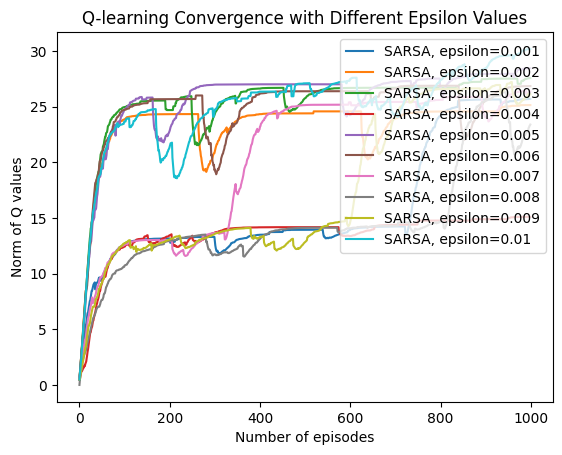

Running for epsilon=0.001
Running for epsilon=0.002
Running for epsilon=0.003
Running for epsilon=0.004
Running for epsilon=0.005
Running for epsilon=0.006
Running for epsilon=0.007
Running for epsilon=0.008
Running for epsilon=0.009
Running for epsilon=0.01


<Figure size 640x480 with 0 Axes>

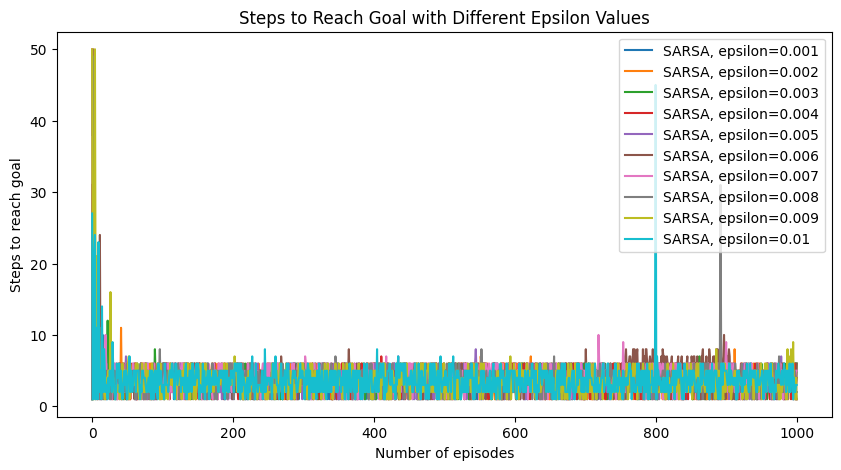

In [40]:
# -------- plot learning curves of SARSA with different epsilon values ----------#
def plot_sarsa_different_epsilons(env, epsilon_values, nb_episodes, timeout, alpha, render):
    plt.clf()
    for epsilon in epsilon_values:
        print(f"Running for epsilon={epsilon}")
        q, q_list, time_list = sarsa_eps(
            env, epsilon, nb_episodes, timeout, alpha, render=render
        )

        # Plot the  norm curves for each epsilon
        plt.plot(range(len(q_list)), q_list, label=f"SARSA, epsilon={epsilon}")

    plt.xlabel("Number of episodes")
    plt.ylabel("Norm of Q values")
    plt.legend(loc="upper right")
    plt.title("Q-learning Convergence with Different Epsilon Values")
    plt.show()

    plt.clf()
    plt.figure(figsize=(10, 5))
    for epsilon in epsilon_values:
        print(f"Running for epsilon={epsilon}")
        q, q_list, time_list = sarsa_eps(
            env, epsilon, nb_episodes, timeout, alpha, render=render
        )

        # Plot the steps-to-goal curves for each epsilon
        plt.plot(range(len(time_list)), time_list, label=f"SARSA, epsilon={epsilon}")

    plt.xlabel("Number of episodes")
    plt.ylabel("Steps to reach goal")
    plt.legend(loc="upper right")
    plt.title("Steps to Reach Goal with Different Epsilon Values")
    plt.show()

# Values to test for epsilon
epsilon_values = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]#np.linspace(0.001, 0.01, 10)

# Call the plotting function to visualize Q-learning performance for different epsilon values
plot_sarsa_different_epsilons(
    env, epsilon_values=epsilon_values, nb_episodes=1000, timeout=100, alpha=0.5, render=False
)



**Comments** :  

Running for beta=0.1...


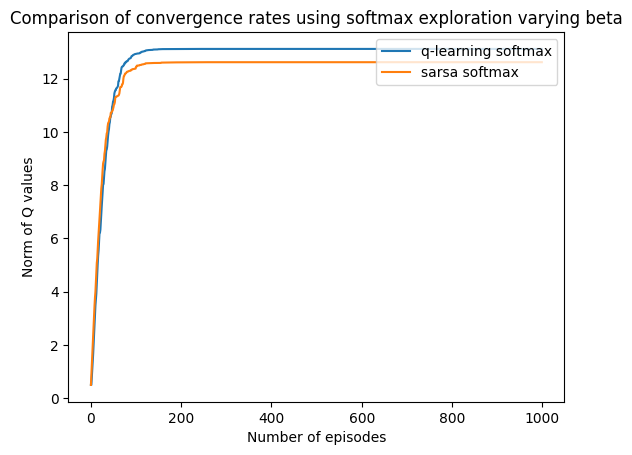

<Figure size 640x480 with 0 Axes>

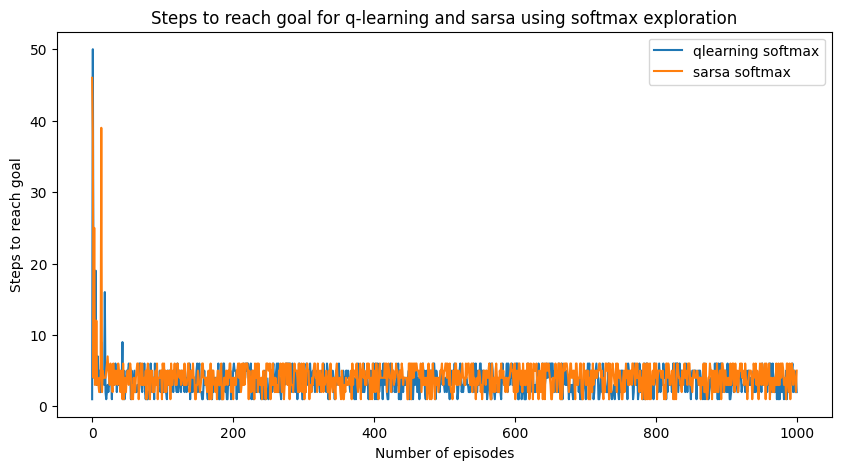

Running for beta=5...


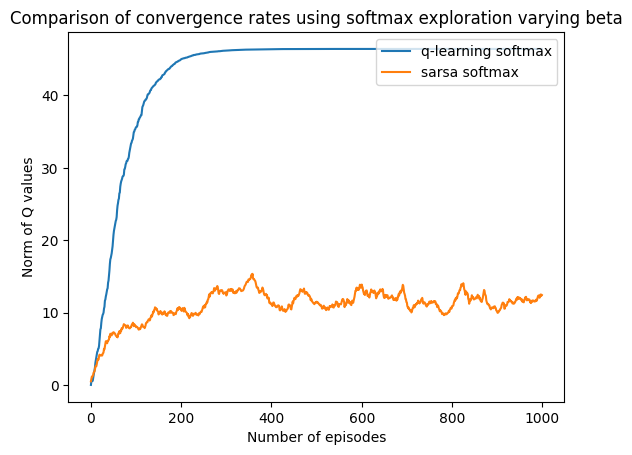

<Figure size 640x480 with 0 Axes>

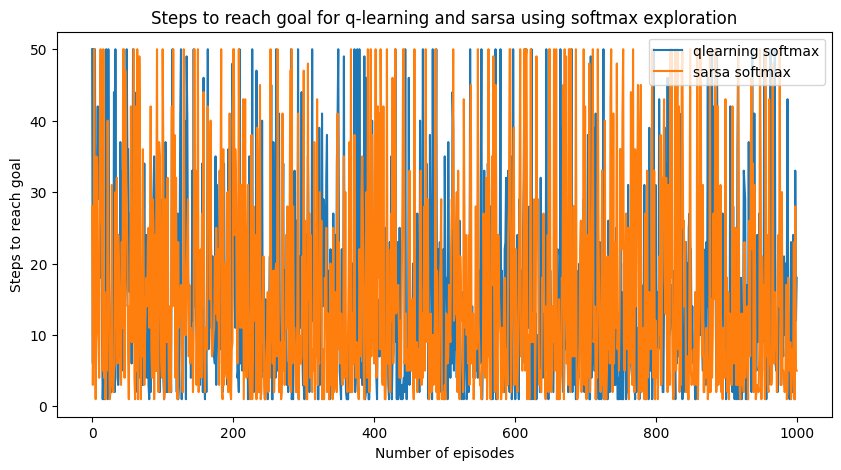

Running for beta=10...


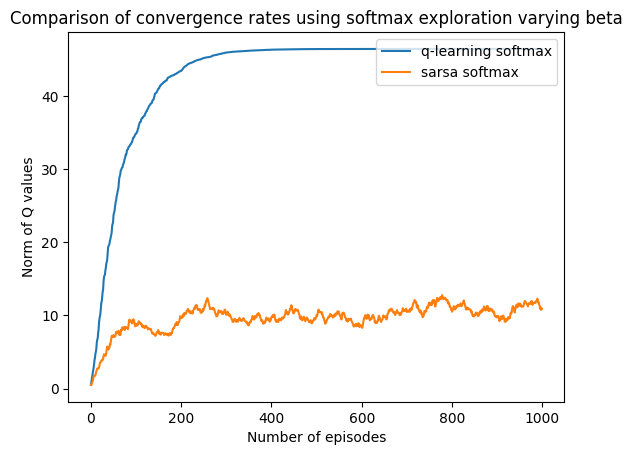

<Figure size 640x480 with 0 Axes>

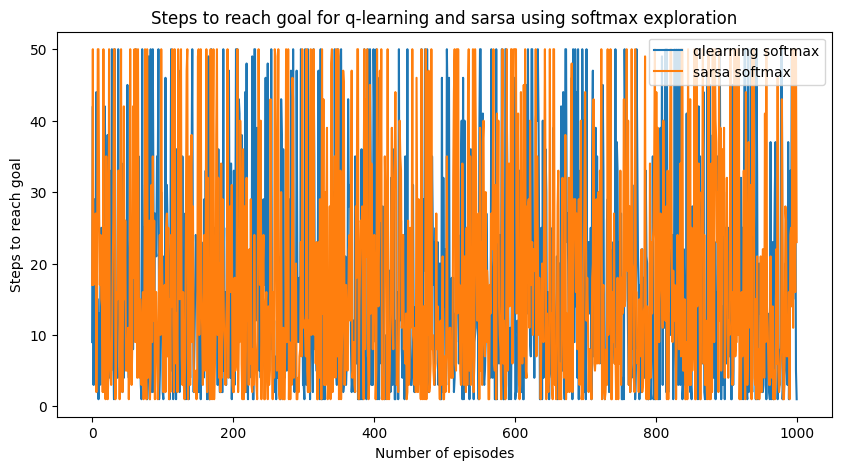

In [26]:
# -------- plot learning curves of Q-Learning and Sarsa using  softmax ----------#
def plot_ql_sarsa_soft(env, beta, nb_episodes, timeout, alpha, render):
    q, q_list2, time_list2 = q_learning_soft(
        env, beta, nb_episodes, timeout, alpha, render =render
    )
    q, q_list4, time_list4 = sarsa_soft(env, beta, nb_episodes, timeout, alpha, render = render)

    plt.clf()
    plt.plot(range(len(q_list2)), q_list2, label="q-learning softmax")
    plt.plot(range(len(q_list4)), q_list4, label="sarsa softmax")

    plt.xlabel("Number of episodes")
    plt.ylabel("Norm of Q values")
    plt.legend(loc="upper right")
    # plt.savefig("comparison_RL.png")
    plt.title("Comparison of convergence rates using softmax exploration varying beta")
    plt.show()

    plt.clf()
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(time_list2)), time_list2, label="qlearning softmax")
    plt.plot(range(len(time_list4)), time_list4, label="sarsa softmax")

    plt.xlabel("Number of episodes")
    plt.ylabel("Steps to reach goal")
    plt.legend(loc="upper right")
    # plt.savefig("comparison_RL.png")
    plt.title("Steps to reach goal for q-learning and sarsa using softmax exploration")
    plt.show()

#Plot to test various beta values (softmax)
beta_values = [0.1, 5, 10]

for beta in beta_values:
    print(f"Running for beta={beta}...")
    # Appel de la fonction avec un paramètre beta et un epsilon arbitraire (ne sera pas utilisé)
    plot_ql_sarsa_soft(
        env, beta=beta, nb_episodes=1000, timeout=100, alpha=0.5, render=False
    )


**Comments** :

The impact of epsilon (ε) in ε-greedy and beta (β) in softmax exploration strategies on q-learning and sarsa algorithms is significant in balancing exploration and exploitation. Epsilon directly controls the probability of random action selection in ε-greedy, with higher values promoting more exploration. Beta, in softmax, determines the degree of randomness in action selection based on qvalues, where higher beta values lead to more deterministic choices.

 One can see on the plots, q-learning tends to converge faster than sarsa. This is because q-learning updates are based on the maximum qvalue of the next state, regardless of the action actually taken. However one can also see, the choice between softmax and ε-greedy can affect this difference. Softmax  provides a more nuanced exploration, leading to faster convergence for both algorithms. ε-greedy, requires more steps to converge, especially with high ε values, but seems to be more stable.

Running for beta=1.0
Running for beta=2.0
Running for beta=3.0
Running for beta=4.0
Running for beta=5.0
Running for beta=6.0
Running for beta=7.0
Running for beta=8.0
Running for beta=9.0
Running for beta=10.0


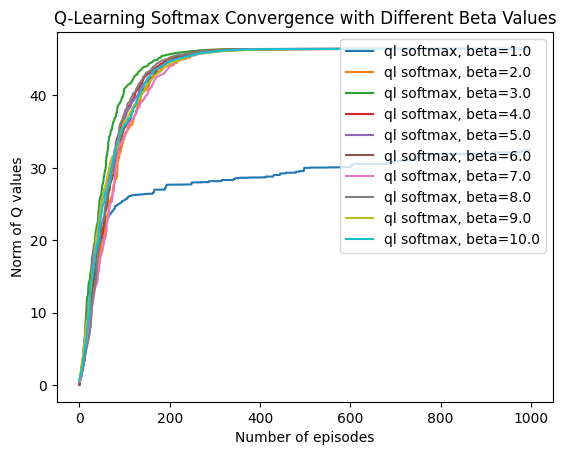

Running for beta=1.0
Running for beta=2.0
Running for beta=3.0
Running for beta=4.0
Running for beta=5.0
Running for beta=6.0
Running for beta=7.0
Running for beta=8.0
Running for beta=9.0
Running for beta=10.0


<Figure size 640x480 with 0 Axes>

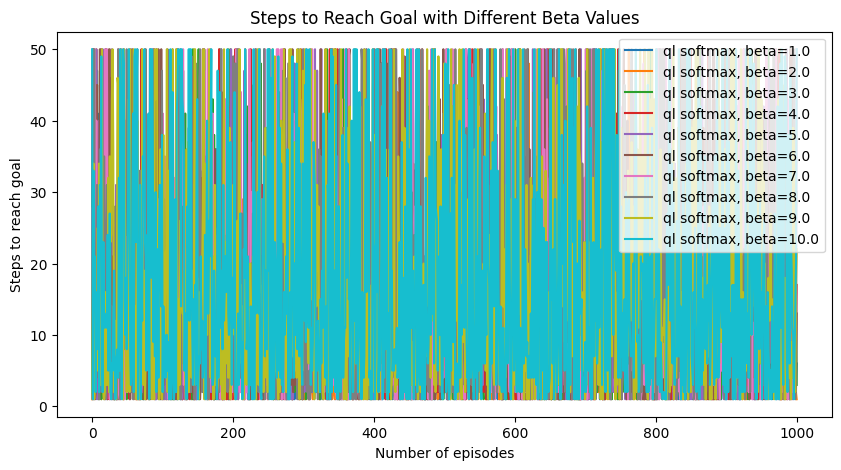

In [42]:
# -------- plot learning curves of Q-Learning with different beta values (softmax) ----------#
def plot_ql_softmax_different_betas(env, beta_values, nb_episodes, timeout, alpha, render):
    plt.clf()
    for beta in beta_values:
        print(f"Running for beta={beta}")
        q, q_list, time_list = q_learning_soft(
            env, beta, nb_episodes, timeout, alpha, render=render
        )

        # Plot the Q-learning norm curves for each beta
        plt.plot(range(len(q_list)), q_list, label=f"ql softmax, beta={beta}")

    plt.xlabel("Number of episodes")
    plt.ylabel("Norm of Q values")
    plt.legend(loc="upper right")
    plt.title("Q-Learning Softmax Convergence with Different Beta Values")
    plt.show()

    plt.clf()
    plt.figure(figsize=(10, 5))
    for beta in beta_values:
        print(f"Running for beta={beta}")
        q, q_list, time_list = q_learning_soft(
            env, beta, nb_episodes, timeout, alpha, render=render
        )

        # Plot the steps-to-goal curves for each beta
        plt.plot(range(len(time_list)), time_list, label=f"ql softmax, beta={beta}")

    plt.xlabel("Number of episodes")
    plt.ylabel("Steps to reach goal")
    plt.legend(loc="upper right")
    plt.title("Steps to Reach Goal with Different Beta Values")
    plt.show()

# Values to test for beta (ranging from 1 to 10 with small steps)
beta_values = np.linspace(1,10, 10)

# Call the plotting function to visualize Q-learning softmax performance for different beta values
plot_ql_softmax_different_betas(
    env, beta_values=beta_values, nb_episodes=1000, timeout=100, alpha=0.5, render=False
)


### Effect of hyper-parameters

The other two hyper-parameters of **q-learning** and **sarsa** are $\alpha$,
and $\gamma$. By varying the values of these hyper-parameters and watching the
learning process and behavior of the agent, explain their impact on the
algorithm. Using additional plotting functions is also welcome.

A good idea to visualize the effect of two parameters is to generate a heat map
by letting both parameters take values in a well-chosen interval

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot learning curves for different values of alpha and gamma
def plot_ql_sarsa_alpha_gamma(env, alpha, gamma, nb_episodes, timeout, epsilon, beta, render):
    # Adjust the environment's discount factor
    #env.gamma = gamma

    # Run the different RL algorithms
    q, q_list1, time_list1 = q_learning_eps(
        env, epsilon, nb_episodes, timeout, alpha, render =render
    )
    q, q_list2, time_list2 = q_learning_soft(
        env, beta, nb_episodes, timeout, alpha,gamma, render =render
    )
    q, q_list3, time_list3 = sarsa_eps(
        env, epsilon, nb_episodes, timeout, alpha, render=render
    )
    q, q_list4, time_list4 = sarsa_soft(env, beta, nb_episodes, timeout, alpha, gamma, render=render)

    # Plot the norm of Q values over episodes
    plt.clf()
    plt.plot(range(len(q_list1)), q_list1, label="q-learning e-greedy")
    plt.plot(range(len(q_list2)), q_list2, label="q-learning softmax")
    plt.plot(range(len(q_list3)), q_list3, label="sarsa e-greedy")
    plt.plot(range(len(q_list4)), q_list4, label="sarsa softmax")

    plt.xlabel("Number of episodes")
    plt.ylabel("Norm of Q values")
    plt.legend(loc="upper right")
    plt.title(f"Convergence (α={alpha}, γ={gamma})")
    plt.show()

    # Plot the number of steps taken per episode
    plt.clf()
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(time_list1)), time_list1, label="q-learning e-greedy")
    plt.plot(range(len(time_list2)), time_list2, label="q-learning softmax")
    plt.plot(range(len(time_list3)), time_list3, label="sarsa e-greedy")
    plt.plot(range(len(time_list4)), time_list4, label="sarsa softmax")

    plt.xlabel("Number of episodes")
    plt.ylabel("Steps to reach goal")
    plt.legend(loc="upper right")
    plt.title(f"Steps to Goal (α={alpha}, γ={gamma})")
    plt.show()

In [28]:

# Loop over different values of alpha and gamma
alpha_values = [0.1, 0.5, 0.9]  # Example learning rates
gamma_values = [0.5, 0.7, 0.9]  # Example discount factors

for alpha in alpha_values:
    for gamma in gamma_values:
        print(f"Testing with alpha={alpha}, gamma={gamma}")
        plot_ql_sarsa_alpha_gamma(
            env, alpha=alpha, gamma=gamma, nb_episodes=1000, timeout=100,
            epsilon=0.02, beta=6, render=False
        )


Output hidden; open in https://colab.research.google.com to view.

**Comments** : In the same way as with the variations of beta and epsilon, these graphs are difficult to analyze, but this time it's because both alpha and gamma influence the algorithms simultaneously. To visualize the effect of these two parameters, we refer to the heat maps. One heat map for each algorithms.

  logger.warn(



Testing with alpha=0.1, gamma=0.5
Testing with alpha=0.1, gamma=0.7
Testing with alpha=0.1, gamma=0.9
Testing with alpha=0.5, gamma=0.5
Testing with alpha=0.5, gamma=0.7
Testing with alpha=0.5, gamma=0.9
Testing with alpha=0.9, gamma=0.5
Testing with alpha=0.9, gamma=0.7
Testing with alpha=0.9, gamma=0.9


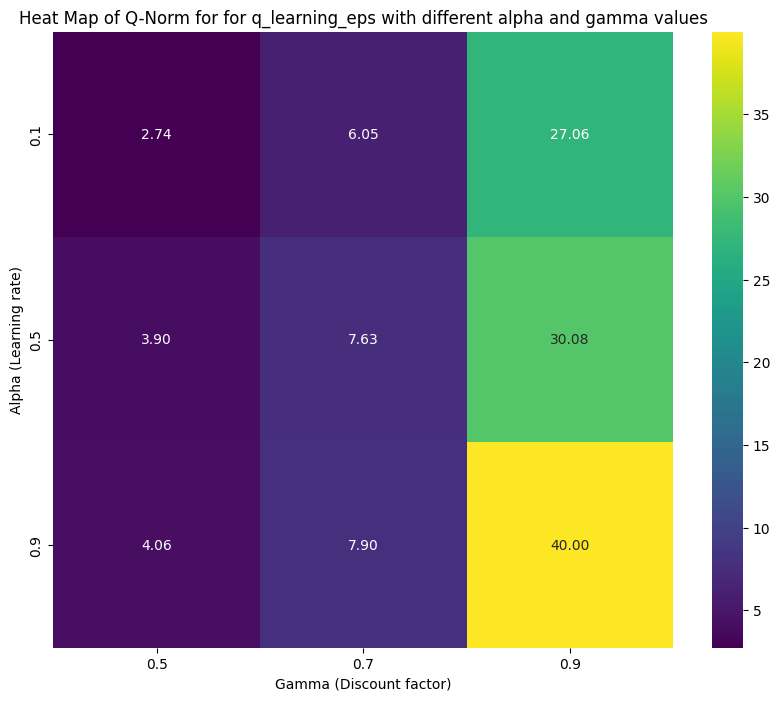

In [29]:
# -------- plot heat map of Q-Learning using e-greedy ----------#
import seaborn as sns
results = np.zeros((len(alpha_values), len(gamma_values)))

# Loop over different values of alpha and gamma
for i, alpha in enumerate(alpha_values):
    for j, gamma in enumerate(gamma_values):
        print(f"Testing with alpha={alpha}, gamma={gamma}")
        q, q_list1, time_list1 = q_learning_eps(
            env, epsilon=0.02, nb_episodes=1000, timeout=100, alpha=alpha,gamma=gamma, render=False
        )
        results[i, j] = np.linalg.norm(q)

# Create heat map for q_learning_eps
plt.figure(figsize=(10, 8))
sns.heatmap(results, annot=True, fmt=".2f", xticklabels=gamma_values, yticklabels=alpha_values, cmap='viridis')
plt.xlabel('Gamma (Discount factor)')
plt.ylabel('Alpha (Learning rate)')
plt.title('Heat Map of Q-Norm for for q_learning_eps with different alpha and gamma values')
plt.show()


  logger.warn(



Testing with alpha=0.1, gamma=0.5
Testing with alpha=0.1, gamma=0.7
Testing with alpha=0.1, gamma=0.9
Testing with alpha=0.5, gamma=0.5
Testing with alpha=0.5, gamma=0.7
Testing with alpha=0.5, gamma=0.9
Testing with alpha=0.9, gamma=0.5
Testing with alpha=0.9, gamma=0.7
Testing with alpha=0.9, gamma=0.9


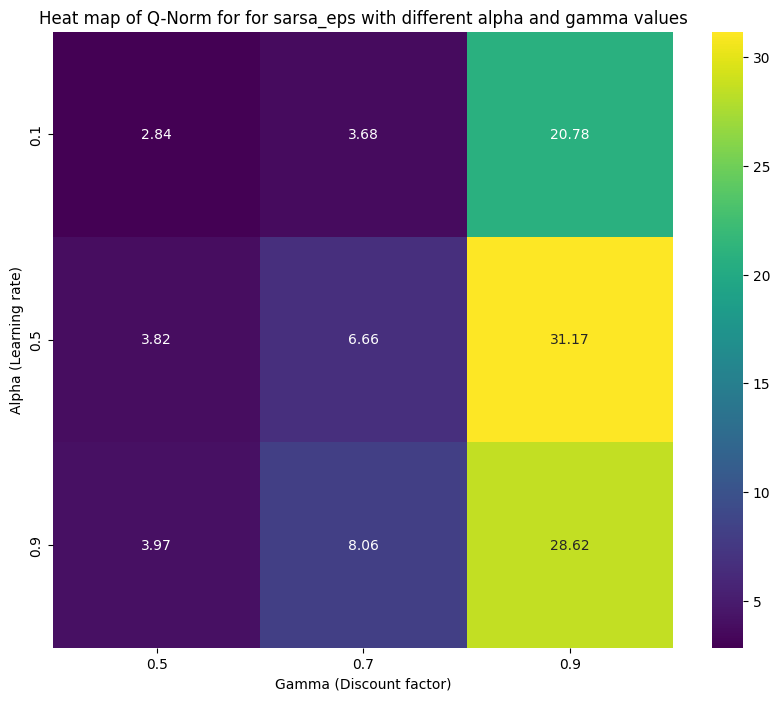

In [30]:
# -------- plot heat map of Sarsa using egreedy ----------#
results = np.zeros((len(alpha_values), len(gamma_values)))

# Loop over different values of alpha and gamma
for i, alpha in enumerate(alpha_values):
    for j, gamma in enumerate(gamma_values):
        print(f"Testing with alpha={alpha}, gamma={gamma}")
        q, q_list1, time_list1 = sarsa_eps(
            env, epsilon=0.02, nb_episodes=1000, timeout=100, alpha=alpha,gamma=gamma, render=False
        )
        results[i, j] = np.linalg.norm(q)

# Create heatmap for sarsa_eps
plt.figure(figsize=(10, 8))
sns.heatmap(results, annot=True, fmt=".2f", xticklabels=gamma_values, yticklabels=alpha_values, cmap='viridis')
plt.xlabel('Gamma (Discount factor)')
plt.ylabel('Alpha (Learning rate)')
plt.title('Heat map of Q-Norm for for sarsa_eps with different alpha and gamma values')
plt.show()

  logger.warn(



Testing with alpha=0.1, gamma=0.5 for q_learning_soft...
Testing with alpha=0.1, gamma=0.7 for q_learning_soft...
Testing with alpha=0.1, gamma=0.9 for q_learning_soft...
Testing with alpha=0.5, gamma=0.5 for q_learning_soft...
Testing with alpha=0.5, gamma=0.7 for q_learning_soft...
Testing with alpha=0.5, gamma=0.9 for q_learning_soft...
Testing with alpha=0.9, gamma=0.5 for q_learning_soft...
Testing with alpha=0.9, gamma=0.7 for q_learning_soft...
Testing with alpha=0.9, gamma=0.9 for q_learning_soft...


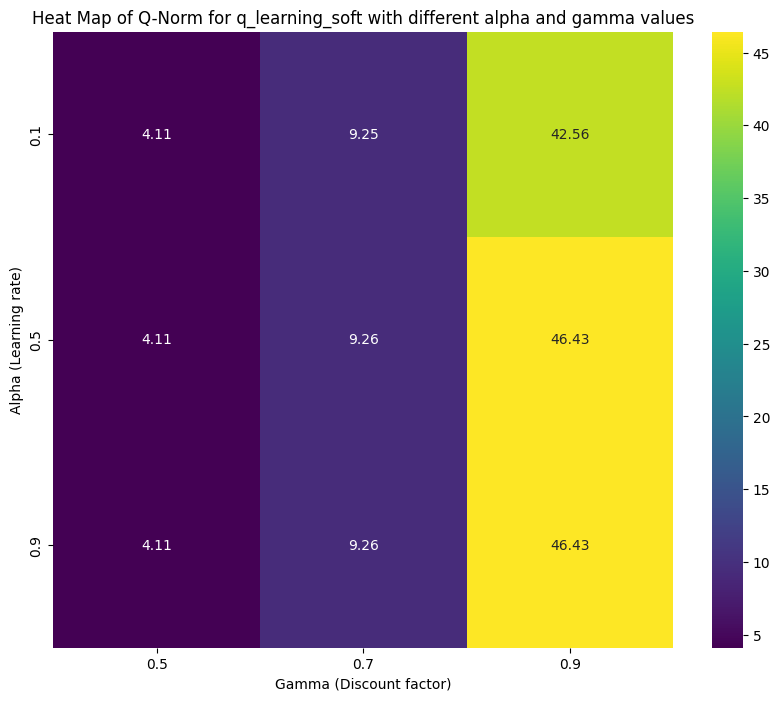

In [31]:
# -------- plot heat map of Q-Learning using  softmax ----------#
results = np.zeros((len(alpha_values), len(gamma_values)))

# Loop over different values of alpha and gamma
for i, alpha in enumerate(alpha_values):
    for j, gamma in enumerate(gamma_values):
        print(f"Testing with alpha={alpha}, gamma={gamma} for q_learning_soft...")
        q, q_list, _ = q_learning_soft(
            env, beta=6, nb_episodes=1000, timeout=100, alpha=alpha,gamma=gamma, render=False
        )
        results[i, j] = np.linalg.norm(q)

# Create heat map for q_learning_soft
plt.figure(figsize=(10, 8))
sns.heatmap(results, annot=True, fmt=".2f", xticklabels=gamma_values, yticklabels=alpha_values, cmap='viridis')
plt.xlabel('Gamma (Discount factor)')
plt.ylabel('Alpha (Learning rate)')
plt.title('Heat Map of Q-Norm for q_learning_soft with different alpha and gamma values')
plt.show()


  logger.warn(



Testing with alpha=0.1, gamma=0.5 for sarsa_soft...
Testing with alpha=0.1, gamma=0.7 for sarsa_soft...
Testing with alpha=0.1, gamma=0.9 for sarsa_soft...
Testing with alpha=0.5, gamma=0.5 for sarsa_soft...
Testing with alpha=0.5, gamma=0.7 for sarsa_soft...
Testing with alpha=0.5, gamma=0.9 for sarsa_soft...
Testing with alpha=0.9, gamma=0.5 for sarsa_soft...
Testing with alpha=0.9, gamma=0.7 for sarsa_soft...
Testing with alpha=0.9, gamma=0.9 for sarsa_soft...


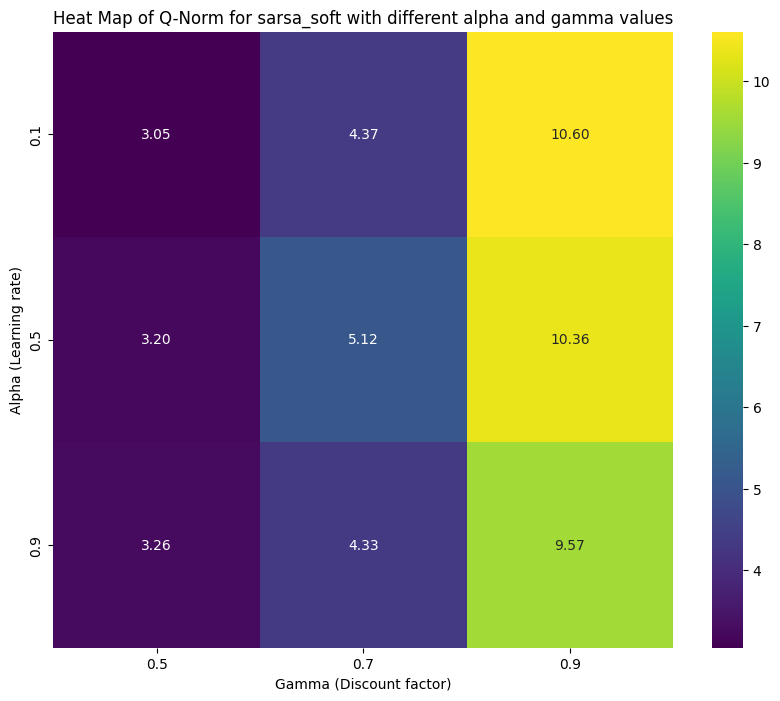

In [32]:
# -------- plot heat map of sarsa using  softmax ----------#
results = np.zeros((len(alpha_values), len(gamma_values)))

# Loop over different values of alpha and gamma
for i, alpha in enumerate(alpha_values):
    for j, gamma in enumerate(gamma_values):
        print(f"Testing with alpha={alpha}, gamma={gamma} for sarsa_soft...")
        q, q_list, _ = sarsa_soft(
            env, beta=6, nb_episodes=1000, timeout=100, alpha=alpha,gamma=gamma, render=False
        )
        results[i, j] = np.linalg.norm(q)

# Create heat map for sarsa_soft
plt.figure(figsize=(10, 8))
sns.heatmap(results, annot=True, fmt=".2f", xticklabels=gamma_values, yticklabels=alpha_values, cmap='viridis')
plt.xlabel('Gamma (Discount factor)')
plt.ylabel('Alpha (Learning rate)')
plt.title('Heat Map of Q-Norm for sarsa_soft with different alpha and gamma values')
plt.show()


**Comments** **: Effect of hyper-parameters**

**Alpha** is the learning rate, it is define as a coefficient that represents how much new information overrides old information. It controls the extent to which the qvalues are updated.
- When alpha has a high value the agent learns quickly from new experiences. On the plot of convergence, one can see that increasing alpha lead to instability and oscillations. The agent is more suceptible to overly react to recent changes in the environment.

- When alpha has a lower value the agent learns more slowly, incorporating new information gradually. The obtained plot shows a stabilization in the learning process.

**Gamma** is the discount factor and determines the importance of future rewards compared to immediate rewards. It reflects how much the agent values long-term rewards over short-term gains.

- In our case when gamma is high it makes the learning process slower, as the agent may take longer to realize the value of immediate rewards. We can see that the norm of Q converge more slowly on the plot where gamma is close to 1.

- At the opposite when it is low it sppeds up learning in the environnemnt as the agent focuses more on immediate rewards.

**Comments on the heat maps**

The impact of gamma (discount factor) and alpha (learning rate) on the algorithm can be observed through the heat map visualization of qvalue norms. Higher values of both parameters lead to larger q norms, represented by lighter colors on the map. Alpha shows a significant influence, with higher values (lower on the y-axis) resulting in increased q norms, suggesting faster learning but potential overestimation. Gamma's impact is evident in the horizontal gradient, where higher values (right side) produce larger q norms, indicating a stronger consideration of future rewards. The combination of high alpha and high gamma (bottom-right corner) yields the highest q norms, demonstrating a compounding effect of rapid learning and long-term reward consideration. However, we know larger q norms don't necessarily equate to better performance in terms of actual rewards. To gain a more comprehensive understanding of the algorithms' performance, it would have been beneficial to create additional heat maps using alternative performance metrics, such as average cumulative reward or success rate, which could provide more direct insights into the actual effectiveness of different parameter combinations.